In [1]:
import os

In [2]:
os.chdir('..')

In [11]:
import os
from typing import Tuple

import click
import numpy as np
import pandas as pd
from tqdm import tqdm

from covidcf.config.dataset import DatasetTarget
from covidcf.data.base import DATA_RAW_PATH, DATA_PROCESSED_PATH, load_visual_features


def load_rumc(target: DatasetTarget) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    df = pd.read_pickle(os.path.join(DATA_PROCESSED_PATH, 'rumc.pkl'))
    return df, df[['Input']], df.Target[target]


RAW_RUMC_PATH = os.path.join(DATA_RAW_PATH, 'covid_ct_CF_anon_with_date_shifts.csv')
RAW_OVERVIEW_PATH = os.path.join(DATA_RAW_PATH, 'overview_20210329.csv')
RAW_DIAGNOSIS_PATH = os.path.join(DATA_RAW_PATH, 'covid_ct_diagnosis_anon.csv')
SPLIT_PATH = os.path.join(DATA_PROCESSED_PATH, 'split.json')

RAW_VIS_TRAIN = os.path.join(DATA_RAW_PATH,
                             "predictions__train_changed['test_csv_version', 'copy_data_to_local']to['12_05_2020_2', True]_features.p.csv")
RAW_VIS_VAL = os.path.join(DATA_RAW_PATH,
                           "predictions__val_changed['test_csv_version', 'copy_data_to_local']to['12_05_2020_2', True]_features.p.csv")
RAW_VIS_TEST = os.path.join(DATA_RAW_PATH,
                            "predictions__test_changed['test_csv_version', 'copy_data_to_local']to['12_05_2020_2', True]_features.p.csv")

# Load raw data
df_rumc = pd.read_csv(RAW_RUMC_PATH, index_col=0)
df_overview = pd.read_csv(RAW_OVERVIEW_PATH)
df_diagnosis = pd.read_csv(RAW_DIAGNOSIS_PATH)

# @click.command()
def process_rumc(pcr_range_min, pcr_range_max, value_range_min, value_range_max):
    # Declare paths
    df_rumc = pd.read_csv(RAW_RUMC_PATH, index_col=0)
    df_overview = pd.read_csv(RAW_OVERVIEW_PATH)
    df_diagnosis = pd.read_csv(RAW_DIAGNOSIS_PATH)

    # Deel with <, >, <=, >= values
    indices = df_rumc.labresultsvalue.str.match(r'[<>]=?(\d*\.?\d*)').fillna(False)
    df_rumc.loc[indices, 'labresultsvalue'] = df_rumc[indices].labresultsvalue.str.extract(r'[<>]=?(\d*\.?\d*)').values

    # Remove + from <number>+
    indices = df_rumc.labresultsvalue.str.match(r'\d+\+').fillna(False)
    df_rumc.loc[indices, 'labresultsvalue'] = df_rumc[indices].labresultsvalue.str.extract(r'(\d+)\+').values

    # Change 'Positief' and 'Negatief' to 1 and 0 repsectively
    # df_rumc.loc[df_rumc.labresultsvalue == 'Positief', 'labresultsvalue'] = 1
    # df_rumc.loc[df_rumc.labresultsvalue == 'Negatief', 'labresultsvalue'] = 0

    # Change sequence of plusses to length of string
    indices = df_rumc.labresultsvalue.str.match(r'\++$').fillna(False)
    df_rumc.loc[indices, 'labresultsvalue'] = df_rumc[indices].labresultsvalue.str.len()

    # Change sequence of minusses to length of string
    indices = df_rumc.labresultsvalue.str.match(r'\-+$').fillna(False)
    df_rumc.loc[indices, 'labresultsvalue'] = -df_rumc[indices].labresultsvalue.str.len()

    # Remove 'Afname' variables
    df_rumc.drop(df_rumc[df_rumc.labresultsname == 'Afname'].index, inplace=True)

    # Deal with log values
    indices = df_rumc.labresultsvalue.str.match(r'log\([<>]\d+\)').fillna(False)
    log_args = df_rumc[indices].labresultsvalue.str.extract(r'log\((.+?)\)').iloc[:, 0]
    df_rumc.loc[indices, 'labresultsvalue'] = np.log(log_args.str.replace('<', '').str.replace('>', '').astype(int))

    # Deal with log ranges
    indices = df_rumc.labresultsvalue.str.match(r'log\(\d+\-\d+\)').fillna(False)
    log_args = df_rumc[indices].labresultsvalue.str.extract(r'log\((\d+)\-(\d+)\)')
    df_rumc.loc[indices, 'labresultsvalue'] = np.log((log_args[0].astype(int) + log_args[1].astype(int)) / 2)

    string_value_counts = df_rumc.labresultsvalue[
        pd.to_numeric(df_rumc.labresultsvalue, errors='coerce').isnull()].value_counts()

    # Remove missing values
    indices = df_rumc.labresultsvalue.str.lower().isin(
        ['niet ontvangen', 'niet te bepalen', 'geannuleerd', 'mislukt', 'vervalt', 'foutief geprikt',
         'te weinig materiaal', 'zie bijlage', 'zie opmerking in het bijlage rapport', 'ontvangen', 'vervalt',
         'handdif_uitgevoerd', 'foutief aangemeld', 'zie toelichting', 'dubieus', 'niet aantoonbaar',
         'niet te berekenen', 'gestold', 'hemolytisch', 'nabepaling niet honoreerbaar'])
    # Remove string values that occur less than 12 times
    indices |= df_rumc.labresultsvalue.isin(string_value_counts[string_value_counts < 12].index.values)
    # Remove metadata values
    indices |= df_rumc.labresultsname.isin(
        ['Status', 'Status 2', 'Afname', 'Product code', 'Product code 2', 'EIN nr.', 'EIN nr. 2', 'Expiratie datum'])
    # Remove whitespace
    indices |= df_rumc.labresultsvalue.str.match(r'\s*$').fillna(False)
    # Remove N codes
    indices |= df_rumc.labresultsvalue.str.match(r'N\d+$').fillna(False)
    # Remove pathologists
    indices |= df_rumc.labresultsvalue.str.startswith('Patholoog').fillna(False)
    # Remove date values
    indices |= df_rumc.labresultsvalue.str.match(r'\d+/\d+/\d+$').fillna(False)
    indices |= df_rumc.labresultsvalue.str.match(r'\d+\-\d+\-\d+$').fillna(False)

    # Set all these to nan
    df_rumc.loc[indices, 'labresultsvalue'] = np.nan

    # Set string null values to 0
    df_rumc.loc[df_rumc.labresultsvalue.isin(['Normaal', 'geen']), 'labresultsvalue'] = 0

    # Parse study dates and extract study id
    df_overview.StudyDate = pd.to_datetime(df_overview.StudyDate, format='%Y%m%d')
    df_overview['StudyId'] = df_overview.StudyPath.str.extract(r'\d+/(.+)')
    df_overview['PatientID'] = df_overview.StudyPath.str.extract(r'(\d+)/.+').astype(np.int64)

    # Compute study dates
    study_dates = df_overview.groupby(['PatientID', 'StudyId']).StudyDate.mean(numeric_only=False)

    # Parse lab value dates
    df_rumc.labresultsresultdate = pd.to_datetime(df_rumc.labresultsresultdate)

    # Determine which study each lab value corresponds to
    df_rumc['study'] = np.nan
    is_pcr = df_rumc.labresultscommonname.str.lower().str.contains(
        'cov') & df_rumc.labresultscommonname.str.lower().str.contains('pcr')
    df_rumc['date_diff'] = np.inf
    for (patient, study), date in tqdm(list(study_dates.iteritems())):
        is_patient = (df_rumc.patientprimarymrn == patient)
        date_diff = (date - df_rumc[is_patient].labresultsresultdate)
        non_pcr_range = ((date_diff <= pd.Timedelta(days=value_range_max)) &
                         (date_diff >= pd.Timedelta(days=-value_range_min)))
#         print(non_pcr_range)
#         print(value_range_min, value_range_max)
        pcr_range = ((date_diff <= pd.Timedelta(days=pcr_range_max)) &
                     (date_diff >= pd.Timedelta(days=-pcr_range_min)))

        idx = non_pcr_range[non_pcr_range].index
        df_rumc.loc[(df_rumc.patientprimarymrn == patient) & (
                    (is_pcr & pcr_range) | (~is_pcr | non_pcr_range)), 'study'] = study
        new_diffs = date_diff / pd.to_timedelta(1, unit='D')
        is_closer = (new_diffs.abs() < df_rumc.loc[is_patient, 'date_diff'].abs())
        new_diffs = new_diffs[is_closer]
        df_rumc.loc[is_patient & is_closer, 'date_diff'] = new_diffs
#         print(df_rumc.loc[idx, 'labresultscommonname'])
    
    # For lab values that do not correspond directly to a single study, add them for each study
    # studies_per_patient = study_dates.index.to_frame()
    # studies_per_patient.rename(columns={'PatientID': 'patientprimarymrn', 'StudyId': 'study'}, inplace=True)
    # df_rumc_no_study = df_rumc[df_rumc.study.isna()].copy()
    # df_rumc_no_study.drop(columns=['study'], inplace=True)
    # df_rumc_no_study_repeated = df_rumc_no_study.merge(studies_per_patient, on='patientprimarymrn')
    #
    # # Merge lab values that correspond directly to a study and those that don't
    # df_rumc_full = pd.concat([df_rumc[~df_rumc.study.isna()], df_rumc_no_study_repeated], ignore_index=True)

    # Bring table into wide form ??????????
#     df_rumc.drop(df_rumc[df_rumc['study'].isna()].index, inplace=True)
    if 1 == 1:
        return df_rumc
    df_pivot = pd.pivot_table(df_rumc[~df_rumc.study.isna()], index=['patientprimarymrn', 'study'],
                              columns=['labresultscommonname'],
                              values='date_diff', aggfunc=lambda x: x.iloc[0])
    print(df_pivot.shape)

    # Load visual features
    vis_train = load_visual_features(RAW_VIS_TRAIN)
    vis_val = load_visual_features(RAW_VIS_VAL)
    vis_test = load_visual_features(RAW_VIS_TEST)

    # Concatenate visual features
    visual_features = pd.concat([vis_train, vis_val, vis_test])

#     import re
#     cat_in_num_vals = [
#         (col,
#          [x for x in df_pivot[col].value_counts().index.values if re.match(r'[+-]?([0-9]*[.])?[0-9]+', str(x)) is None])
#         for col in df_pivot.select_dtypes(include='category').iloc[:, np.where(
#             [df_pivot[col].str.match(r'[+-]?([0-9]*[.])?[0-9]+').any() for col in
#              df_pivot.select_dtypes(include='category').columns])[0]].columns]

#     assert len(cat_in_num_vals) == 0

    # Join lab and visual features
    df_pivot = df_pivot.join(visual_features, how='outer')

    # Add sex and age
    df_pivot_reindexed = df_pivot.copy()
    df_pivot_reindexed['study'] = df_pivot_reindexed.index.get_level_values(1)
    df_pivot_reindexed.index = df_pivot.index.get_level_values(0)
    df_pivot_reindexed['age'] = df_rumc.groupby(['patientprimarymrn']).patientage.mean()
    df_pivot_reindexed['sex'] = df_rumc.groupby(['patientprimarymrn']).patientsex.first()
    df_pivot = df_pivot_reindexed.set_index(['study'], append=True)

    # Compress PCR to single column
    pcr = df_pivot.loc[:,
          df_pivot.columns.str.lower().str.contains('cov') & df_pivot.columns.str.lower().str.contains('pcr')].apply(
        lambda x: x[x.first_valid_index()] if x.first_valid_index() is not None else np.nan, axis=1)
    df_pivot.drop(columns=df_pivot.columns[
        df_pivot.columns.str.lower().str.contains('cov') & (
                df_pivot.columns.str.lower().str.contains('pcr') | df_pivot.columns.str.lower().str.contains(
            'ig'))],
                  inplace=True)
    df_pivot['pcr'] = pcr

    # Load split data
    import json
    with open(SPLIT_PATH) as f:
        split = json.load(f)

    # Convert to dataframes
    train_split = pd.DataFrame(split['train'])
    train_split['part'] = 'train'
    val_split = pd.DataFrame(split['val'])
    val_split['part'] = 'val'
    test_split = pd.DataFrame(split['test'])
    test_split['part'] = 'test'

    # Join to other data
    df_split = pd.concat([train_split, val_split, test_split])
    df_split.rename(columns={'patientid': 'patientprimarymrn', 'y': 'corads'}, inplace=True)
    df_split.drop(columns=['x'], inplace=True)
    df_split.set_index(['patientprimarymrn', 'study'], inplace=True)

    df_pivot = df_pivot.join(df_split)

    # Process diagnosis data
    df_diagnosis.diagnosisstartdate = pd.to_datetime(df_diagnosis.diagnosisstartdate)
    df_diagnosis['study'] = np.nan
#     for (patient, study), date in study_dates.iteritems():
#         df_diagnosis.loc[(df_diagnosis.patientprimarymrn == patient) &
#                          ((date - df_diagnosis.diagnosisstartdate) <= pd.Timedelta(days=14)) &
#                          ((date - df_diagnosis.diagnosisstartdate) >= pd.Timedelta(days=-14)), 'study'] = study

    df_diagnosis.drop(df_diagnosis[df_diagnosis.study.isna()].index, inplace=True)
    df_diagnosis.set_index(['patientprimarymrn', 'study'], inplace=True)
    s_diagnosis = df_diagnosis[['diagnosishospitaldiagnosis', 'diagnosisemergencydepartmentdiagnosis']].mean(axis=1)
    s_diagnosis = s_diagnosis[~s_diagnosis.index.duplicated(keep='first')]
    df_pivot['diagnosis'] = s_diagnosis

    non_visual_features = list(df_pivot.columns[~df_pivot.columns.isin(
        ['pcr', 'corads', 'diagnosis', 'part']) & ~df_pivot.columns.str.startswith('vis_')])
    visual_features = list(df_pivot.columns[df_pivot.columns.str.startswith('vis_')])
    target_features = ['pcr', 'corads', 'diagnosis']
    meta_features = ['part']

    def get_nested_col(col):
        if col in non_visual_features:
            return 'Input', 'Clinical', col
        elif col in visual_features:
            return 'Input', 'Visual', col
        elif col in target_features:
            return 'Target', col, ''
        elif col in meta_features:
            return 'Meta', col, ''

    new_cols = [get_nested_col(col) for col in df_pivot.columns]
    df_pivot.columns = pd.MultiIndex.from_tuples(new_cols)

    # Fix dtypes
    for col in df_pivot.columns:
        try:
            df_pivot[col] = pd.to_numeric(df_pivot[col], errors='raise')
        except ValueError:
            df_pivot[col] = df_pivot[col].astype('category')
            # num_cats = df_pivot[col].cat.categories[df_pivot[col].cat.categories.str.match(r'\d+', na=False)]
            # df_pivot[col].cat.rename_categories({cat: 'v' + cat for cat in num_cats}, inplace=True)
            # df_pivot[col].cat.add_categories(['Missing'], inplace=True)
            # df_pivot[col].fillna('Missing', inplace=True)
    return df_pivot

In [4]:
results = []
mins = np.linspace(0.01, 50, 40)
maxs = np.linspace(0.01, 50, 40)

In [5]:
for range_min in (mins):
    for range_max in maxs:
#         df_pivot = process_rumc(14, 14, range_min, range_max)
#         row = {'min': range_min, 'max': range_max, 
#                         'percentage': (~df_pivot.Input.isna()).sum().sum()/len(df_pivot.values.ravel()), 
#                         'n_present': (~df_pivot.Input.isna()).sum().sum()}
#         row.update(dict((~df_pivot.Input.isna()).sum()))
#         row = {'min': range_min, 'max': range_max, 
#                'n_present': ((feats < range_max) & (feats > -range_min)).sum().sum(), 
#                'n_features': (((feats < range_max) & (feats > -range_min)).sum() > feats.shape[0]*0.16).sum()}
        row = {'min': range_min, 'max': range_max, 'n_present': ((df_test2.date_diff > -range_min) & (df_test2.date_diff < range_max)).sum()}
        results.append(row)

NameError: name 'df_test2' is not defined

In [ ]:
pd.DataFrame({'a': [1, 2, 3, 4, 5]}, index=[1, 2, 3, 4, 5]).loc[pd.Series([True, True, True, True], index=[1, 2, 4, 5]).index]

In [363]:
results_df = pd.DataFrame(results)

In [160]:
df_pivot.index.get_level_values(1).isna().any()

False

In [161]:
results_df['num_features'] = (results_df.iloc[:, 4:] > int(df_pivot.shape[0]*0.16)).sum(axis='columns')

In [107]:
pd.pivot(results_df[['min', 'max', 'n_present']], index='min', columns='max', values='percentage')

KeyError: "['n_present'] not in index"

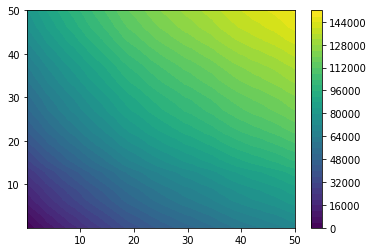

In [364]:
import matplotlib.pyplot as plt
plt.contourf(mins, maxs, pd.pivot(results_df[['min', 'max', 'n_present']], index='min', columns='max', values='n_present').values, levels=40)
plt.colorbar()

In [255]:
df_processed = pd.read_pickle('data/processed/rumc.pkl')

In [258]:
X = df_processed.Input.Clinical
y = df_processed.Target.pcr
X = X[~y.isna()]
y = y[~y.isna()]

In [311]:
(~X.isna()).sum().sort_values(ascending=False)[:10]

sex                                  155
age                                  155
KREATININE                           135
RED CELL DISTRIBUTION WIDTH (RDW)    135
LEUK                                 135
HEMOGLOBINE                          135
HEMATOCRIET                          135
MCH                                  135
MCHC                                 135
ERYTROCYTEN                          135
dtype: int64

In [27]:
(~pd.read_pickle('data/processed/rumc.pkl').Target.pcr.isna()).sum()

155

In [35]:
ictcf = pd.read_pickle('data/processed/ictcf.pkl')

In [38]:
ictcf[ictcf.Meta.hospital != 'Union']

Input                                                                \
      Clinical                                                                 
     Value_5NT Value_AFU Value_ALB Value_ALG Value_ALP Value_ALT Value_APOA1   
775        NaN       NaN -0.660000       NaN   0.32750  0.378049         NaN   
776        NaN       NaN -0.620000       NaN   0.16375  0.465854         NaN   
777        NaN    0.4600 -0.620000       NaN  -0.06250  0.104878   -0.500000   
778        NaN       NaN  0.046667       NaN   0.54000  0.156098         NaN   
779        NaN       NaN -0.513333       NaN  -0.23000  2.065854         NaN   
...        ...       ...       ...       ...       ...       ...         ...   
1165       NaN    0.4475  0.220000       NaN  -0.07250  0.380488    0.083333   
1166       NaN       NaN       NaN       NaN       NaN       NaN         NaN   
1167       NaN       NaN       NaN       NaN       NaN       NaN         NaN   
1168       NaN       NaN -0.026667       NaN   0.22625  0.339024         NaN   
1169       NaN       NaN -0.200000       NaN   0.63000  0.151220   -0.533333   

                                      ...                                \
                                      ...         Visual                  
     Value_APOB Value_APTT Value_ASO  ... vis_feature_51 vis_feature_52   
775         NaN   0.222222       NaN  ...       3.015334       1.130375   
776         NaN   0.761905       NaN  ...       1.215210       0.404549   
777        1.20        NaN       NaN  ...       2.734528       0.671472   
778         NaN   0.444444       NaN  ...       0.242518       0.853494   
779         NaN   0.857143       NaN  ...       4.375770       1.873959   
...         ...        ...       ...  ...            ...            ...   
1165      -0.40   1.714286       NaN  ...      -1.358442      -1.294718   
1166        NaN        NaN       NaN  ...      -1.179440      -0.997562   
1167        NaN        NaN       NaN  ...      -0.937820      -0.692365   
1168        NaN   1.126984       NaN  ...            NaN            NaN   
1169       0.16        NaN       NaN  ...            NaN            NaN   

                                                                  \
                                                                   
     vis_feature_53 vis_feature_54 vis_feature_55 vis_feature_56   
775        1.154524       1.117130       1.137948      -0.156387   
776        0.344093       0.388476       0.324084      -0.140255   
777        0.666334       0.656430       0.646565      -0.412582   
778        0.874880       0.856231       0.872382       0.787813   
779        1.934840       1.855636       1.912520       0.156916   
...             ...            ...            ...            ...   
1165      -1.267605      -1.251506      -1.231013      -0.964285   
1166      -0.990535      -1.014165      -1.010986      -0.694839   
1167      -0.680393      -0.700467      -0.693486      -0.445468   
1168            NaN            NaN            NaN            NaN   
1169            NaN            NaN            NaN            NaN   

                                                    Meta  
                                                  cohort  
     vis_feature_57 vis_feature_58 vis_feature_59         
775       -0.162790      -0.177624      -0.232395     c1  
776       -0.177321      -0.168228      -0.258743     c1  
777       -0.424413      -0.424238      -0.487179     c1  
778        0.781632       0.768761       0.714631     c1  
779        0.164849       0.128887       0.089049     c1  
...             ...            ...            ...    ...  
1165      -0.962545      -0.950400      -1.001903     c1  
1166      -0.702461      -0.715773      -0.769862     c1  
1167      -0.458304      -0.470708      -0.534563     c1  
1168            NaN            NaN            NaN     c1  
1169            NaN            NaN            NaN     c1  

[395 rows x 193 columns]

In [41]:
(ictcf.Target.pcr == 'Positive').sum()

945

In [42]:
cwz = pd.read_pickle('data/processed/cwz.pkl')
cwz

Input                              \
                               Visual                               
                        vis_feature_0 vis_feature_1 vis_feature_2   
patientprimarymrn study                                             
10057             st000     -0.430173     -0.480251     -0.393809   
10059             st000      0.375762      0.433246      0.316076   
10063             st000      2.176036      2.254850      1.581754   
10061             st000      0.411439      0.458757      0.365130   
10062             st000      2.368320      2.375811      2.052492   
...                               ...           ...           ...   
CWZ-CORADS-258    NaN        0.248527      0.238376      0.231960   
CWZ-CORADS-259    NaN        1.902460      1.845935      1.820220   
CWZ-CORADS-260    NaN       -0.851612     -0.808516     -0.774081   
CWZ-CORADS-261    NaN        0.359975      0.414118      0.336472   
CWZ-CORADS-262    NaN       -0.885957     -0.867529     -0.871148   

                                                                   \
                                                                    
                        vis_feature_3 vis_feature_4 vis_feature_5   
patientprimarymrn study                                             
10057             st000     -0.446336     -0.327011     -0.421855   
10059             st000      0.372820      0.262803      0.241065   
10063             st000      1.655809      2.005412      2.082397   
10061             st000      0.409756      0.685254      0.741976   
10062             st000      2.062543      3.129250      3.172685   
...                               ...           ...           ...   
CWZ-CORADS-258    NaN        0.222172      0.212596      0.186934   
CWZ-CORADS-259    NaN        1.766721      1.965016      1.910413   
CWZ-CORADS-260    NaN       -0.736979     -0.676727     -0.612525   
CWZ-CORADS-261    NaN        0.387573      0.378910      0.404797   
CWZ-CORADS-262    NaN       -0.853923     -0.837123     -0.822126   

                                                                   \
                                                                    
                        vis_feature_6 vis_feature_7 vis_feature_8   
patientprimarymrn study                                             
10057             st000     -0.283105     -0.380743     -0.118672   
10059             st000      0.236138      0.213918      0.012551   
10063             st000      1.396364      1.468067      0.536915   
10061             st000      0.663871      0.717062      0.886520   
10062             st000      2.824704      2.868799      3.549509   
...                               ...           ...           ...   
CWZ-CORADS-258    NaN        0.202685      0.176898      0.222940   
CWZ-CORADS-259    NaN        1.888274      1.836990      1.559038   
CWZ-CORADS-260    NaN       -0.578829     -0.522654     -0.109845   
CWZ-CORADS-261    NaN        0.372611      0.395199      0.263762   
CWZ-CORADS-262    NaN       -0.816426     -0.802738     -0.333470   

                                       ...                                  \
                                       ...     Clinical                      
                        vis_feature_9  ... adm_ferritin adm_ddimer adm_LDH   
patientprimarymrn study                ...                                   
10057             st000     -0.259182  ...         48.0        NaN   198.0   
10059             st000     -0.134137  ...          NaN        NaN   213.0   
10063             st000      0.578688  ...          NaN        NaN   219.0   
10061             st000      0.948917  ...          NaN        NaN   791.0   
10062             st000      3.600445  ...        406.0        NaN   238.0   
...                               ...  ...          ...        ...     ...   
CWZ-CORADS-258    NaN        0.177596  ...         73.0        0.3   270.0   
CWZ-CORADS-259    NaN        1.574247  ...       4414.0        1.8

In [49]:
ictcf.to_csv('data/processed/ictcf.csv')

In [312]:
X.shape

(155, 1325)

In [317]:
feats.loc[~df_test2.Target.pcr.isna()].shape

(41, 478)

In [320]:
df_processed.shape, feats.shape

((814, 1389), (800, 478))

In [329]:
(~df_processed.loc[list(set(df_processed.index) - set(feats.index))].isna()).sum().sort_values(ascending=False)[:10]

Input  Clinical  TROMBOCYTEN                    14
                 O2 SATURATIE (BLOEDGAS)        14
                 GLUCOSE (BLOEDGAS)             14
                 METHEMOGLOBINE (BLOEDGAS)      14
                 ERYTROCYTEN                    14
                 CKD-EPI-GFR, ML/MIN/1.73 M2    14
                 PO2 (BLOEDGAS)                 14
                 KREATININE                     14
                 PCO2 (BLOEDGAS)                14
                 LEUK                           14
dtype: int64

In [331]:
df_test2.loc[list(set(df_processed.index) - set(feats.index))]

KeyError: "None of [MultiIndex([(10251, 'st001'),\n            (10533, 'st001'),\n            (10192, 'st001'),\n            (10538, 'st001'),\n            (10332, 'st001'),\n            (10366, 'st002'),\n            (10205, 'st001'),\n            (10170, 'st002'),\n            (10071, 'st002'),\n            (10025, 'st001'),\n            (10548, 'st001'),\n            (10011, 'st001'),\n            (10191, 'st001'),\n            (10560, 'st001')],\n           names=['patientprimarymrn', 'study'])] are in the [index]"

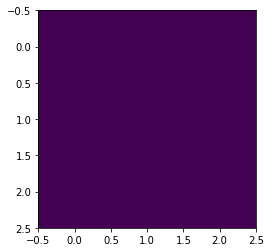

In [62]:
plt.imshow(pd.pivot(results_df[['min', 'max', 'percentage']], index='min', columns='max', values='percentage').values)

In [100]:
df_test1 = process_rumc(14, 14, 1, 1)

100%|███████████████████████████████████████████████████████| 1205/1205 [00:16<00:00, 71.28it/s]


In [12]:
df_test2 = process_rumc(14, 14, 30, 30)

100%|███████████████████████████████████████████████████████| 1205/1205 [02:37<00:00,  7.67it/s]


In [14]:
df_test2[~df_test2.study.isna()]

,patientprimarymrn,patientage,patientsex,labresultsvalue,labresultsnumericvalue,labresultsunit,labresultsname,labresultsbasename,labresultscommonname,labresultsabbreviation,labresultstype,labresultscount,labresultssubtype,labresultsresultdate,study,date_diff
0,10559,70,Vrouw,1,NaN,NaN,Abnormaal kernchromatine,KERNCHRCHL,ABNORMAAL KERNCHROMATINE CHL,NaN,*Unspecified,1,*Unspecified,2020-04-25 04:19:12,st000,-2.18
1,10559,70,Vrouw,1,NaN,NaN,Abnormaal kernchromatine,KERNCHRCHL,ABNORMAAL KERNCHROMATINE CHL,NaN,*Unspecified,1,*Unspecified,2020-07-09 04:19:12,st000,-77.18
2,10559,70,Vrouw,1,NaN,NaN,Afwijk. lymfo suspect reactief,ALRCHL,AFWIJK. LYMFO SUSPECT REACTIEF,afwlymsusr,*Unspecified,1,*Unspecified,2020-04-25 04:19:12,st000,-2.18
3,10559,70,Vrouw,1,NaN,NaN,Afwijkende lymfocyten suspect reactief,ALR,AFWIJKENDE LYMFOCYTEN SUSPECT REACTIEF,NaN,*Unspecified,1,*Unspecified,2019-12-20 04:19:12,st000,124.82
4,10559,70,Vrouw,1,NaN,NaN,Afwijkende lymfocyten suspect reactief,ALR,AFWIJKENDE LYMFOCYTEN SUSPECT REACTIEF,NaN,*Unspecified,1,*Unspecified,2020-01-17 04:19:12,st000,96.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,10340,70,Vrouw,Staphylococcus epidermidis,NaN,< (groeidichtheid),Algemene kweek (Weefsel),AW,ALGEMENE KWEEK (WEEFSEL),NaN,*Unspecified,1,*Unspecified,2020-03-03 15:50:24,st000,29.34
274543,10340,70,Vrouw,Staphylococcus epidermidis,NaN,< (groeidichtheid),Algemene kweek (Weefsel),AW,ALGEMENE KWEEK (WEEFSEL),NaN,*Unspecified,1,*Unspecified,2020-03-09 15:50:24,st000,23.34
274544,10340,70,Vrouw,Staphylococcus epidermidis,NaN,1 (groeidichtheid ),Algemene kweek (Weefsel),AW,ALGEMENE KWEEK (WEEFSEL),NaN,*Unspecified,1,*Unspecified,2020-03-09 15:50:24,st000,23.34
274545,10340,70,Vrouw,NaN,NaN,INR,INR,INR,ORALE ANTISTOLLING,NaN,*Unspecified,1,*Unspecified,2020-04-24 15:50:24,st000,-22.66


In [16]:
df_test2.drop(df_test2[df_test2['study'].isna()].index)

,patientprimarymrn,patientage,patientsex,labresultsvalue,labresultsnumericvalue,labresultsunit,labresultsname,labresultsbasename,labresultscommonname,labresultsabbreviation,labresultstype,labresultscount,labresultssubtype,labresultsresultdate,study,date_diff
0,10559,70,Vrouw,1,NaN,NaN,Abnormaal kernchromatine,KERNCHRCHL,ABNORMAAL KERNCHROMATINE CHL,NaN,*Unspecified,1,*Unspecified,2020-04-25 04:19:12,st000,-2.18
1,10559,70,Vrouw,1,NaN,NaN,Abnormaal kernchromatine,KERNCHRCHL,ABNORMAAL KERNCHROMATINE CHL,NaN,*Unspecified,1,*Unspecified,2020-07-09 04:19:12,st000,-77.18
2,10559,70,Vrouw,1,NaN,NaN,Afwijk. lymfo suspect reactief,ALRCHL,AFWIJK. LYMFO SUSPECT REACTIEF,afwlymsusr,*Unspecified,1,*Unspecified,2020-04-25 04:19:12,st000,-2.18
3,10559,70,Vrouw,1,NaN,NaN,Afwijkende lymfocyten suspect reactief,ALR,AFWIJKENDE LYMFOCYTEN SUSPECT REACTIEF,NaN,*Unspecified,1,*Unspecified,2019-12-20 04:19:12,st000,124.82
4,10559,70,Vrouw,1,NaN,NaN,Afwijkende lymfocyten suspect reactief,ALR,AFWIJKENDE LYMFOCYTEN SUSPECT REACTIEF,NaN,*Unspecified,1,*Unspecified,2020-01-17 04:19:12,st000,96.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,10340,70,Vrouw,Staphylococcus epidermidis,NaN,< (groeidichtheid),Algemene kweek (Weefsel),AW,ALGEMENE KWEEK (WEEFSEL),NaN,*Unspecified,1,*Unspecified,2020-03-03 15:50:24,st000,29.34
274543,10340,70,Vrouw,Staphylococcus epidermidis,NaN,< (groeidichtheid),Algemene kweek (Weefsel),AW,ALGEMENE KWEEK (WEEFSEL),NaN,*Unspecified,1,*Unspecified,2020-03-09 15:50:24,st000,23.34
274544,10340,70,Vrouw,Staphylococcus epidermidis,NaN,1 (groeidichtheid ),Algemene kweek (Weefsel),AW,ALGEMENE KWEEK (WEEFSEL),NaN,*Unspecified,1,*Unspecified,2020-03-09 15:50:24,st000,23.34
274545,10340,70,Vrouw,NaN,NaN,INR,INR,INR,ORALE ANTISTOLLING,NaN,*Unspecified,1,*Unspecified,2020-04-24 15:50:24,st000,-22.66


In [24]:
df_range = df_test2[((df_test2.date_diff > -3) & (df_test2.date_diff < 3))]

In [344]:
feats = df_test2.Input.Clinical.loc[:, ~df_test2.Input.Clinical.columns.isin(['sex', 'age'])]

AttributeError: 'DataFrame' object has no attribute 'Input'

In [341]:
feats.shape

(811, 1620)

In [309]:
((feats < 3) & (feats > -3)).sum().sort_values(ascending=False)[:10]

MDRD-GFR                             124
KREATININE                           124
CKD-EPI-GFR, ML/MIN/1.73 M2          124
MCV                                  123
MCHC                                 123
HEMATOCRIET                          123
HEMOGLOBINE                          123
MCH                                  123
RED CELL DISTRIBUTION WIDTH (RDW)    123
LEUK                                 123
dtype: int64

In [95]:
(~df_test1.isna()).sum().sum(), df_test1.shape

(52805, (799, 352))

In [101]:
(~df_test1.isna()).sum().sum(), df_test1.shape

(53581, (799, 352))

In [99]:
(~df_test2.isna()).sum().sum(), df_test2.shape

(91091, (810, 1182))

In [96]:
(~df_test2.isna()).sum().sum(), df_test2.shape

(91073, (810, 1182))

In [33]:
(~df_test.Input.isna()).sum().sum()/len(df_test.values.ravel())

0.09115231469443133

In [37]:
test_dict = {'ewfew': 4}
test_dict.update(dict((~df_test.Input.isna()).sum()))
test_dict

{'ewfew': 4,
 ('Clinical', '(PSEUDO) PELGER HUET'): 3,
 ('Clinical', '(PSEUDO) PELGER HUET CHL'): 3,
 ('Clinical', '3-METHOXYTYRAMINE'): 4,
 ('Clinical', '5-HIAA (24U URINE)'): 1,
 ('Clinical', '6-MMPR (AZATHIOPRINE/MERCAPTOPURINE)'): 2,
 ('Clinical', '6-MMPR-R (AZATHIOPRINE/MERCAPTOPURINE)'): 1,
 ('Clinical', '6-TGN (AZATHIOPRINE/MERCAPTOPURINE)'): 2,
 ('Clinical', '6-TGN-R (AZATHIOPURINE/MERCAPTOPURINE)'): 1,
 ('Clinical', 'AA(M)'): 24,
 ('Clinical', 'AAL'): 26,
 ('Clinical', 'AAM6452'): 24,
 ('Clinical', 'AANTAL AFERESEZAKKEN AANWEZIG'): 1,
 ('Clinical', 'AANTAL ERYTROBLASTEN / 100 LEUCO S'): 25,
 ('Clinical', 'AANTAL GEPLANDE TRANSPLANTATIES'): 1,
 ('Clinical', 'AANTAL LITER PROCESSED'): 1,
 ('Clinical', 'AB0/RH. D BLOEDGROEP'): 180,
 ('Clinical', 'ABNORMAAL KERNCHROMATINE'): 24,
 ('Clinical', 'ABNORMAAL KERNCHROMATINE CHL'): 3,
 ('Clinical', 'ABNORMALE HEMOGLOBINES'): 1,
 ('Clinical', 'ACE'): 6,
 ('Clinical', 'ACETO-ACETAAT T1'): 1,
 ('Clinical', 'ACETYLAZIJNZUUR'): 2,
 ('Clinical